# EA Implementation 3.1

🔥 Using device: cpu

=== Generation 1/3 ===
[0:00:00] Episode 0/800 | Avg reward: 2.00


C:\Users\akshi\AppData\Local\Temp\ipykernel_2664\1354053466.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.observation])
C:\Users\akshi\AppData\Local\Temp\ipykernel_2664\1354053466.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.next_observation])


[0:00:04] Episode 25/800 | Avg reward: 29.92
[0:00:09] Episode 50/800 | Avg reward: 30.84
[0:00:16] Episode 75/800 | Avg reward: 40.84
[0:00:26] Episode 100/800 | Avg reward: 53.36
[0:00:35] Episode 125/800 | Avg reward: 52.32
[0:00:48] Episode 150/800 | Avg reward: 59.28
[0:01:03] Episode 175/800 | Avg reward: 70.40
[0:01:15] Episode 200/800 | Avg reward: 58.12
[0:01:29] Episode 225/800 | Avg reward: 66.08
[0:01:44] Episode 250/800 | Avg reward: 70.80
[0:02:01] Episode 275/800 | Avg reward: 88.00
[0:02:15] Episode 300/800 | Avg reward: 98.84
[0:02:38] Episode 325/800 | Avg reward: 133.96
[0:02:53] Episode 350/800 | Avg reward: 84.76
[0:03:12] Episode 375/800 | Avg reward: 106.16
[0:03:30] Episode 400/800 | Avg reward: 93.16
[0:03:50] Episode 425/800 | Avg reward: 106.20
[0:04:09] Episode 450/800 | Avg reward: 98.92
[0:04:29] Episode 475/800 | Avg reward: 101.76
[0:04:53] Episode 500/800 | Avg reward: 123.64
[0:04:53] 💾 Backup saved at episode 500
[0:05:16] Episode 525/800 | Avg reward

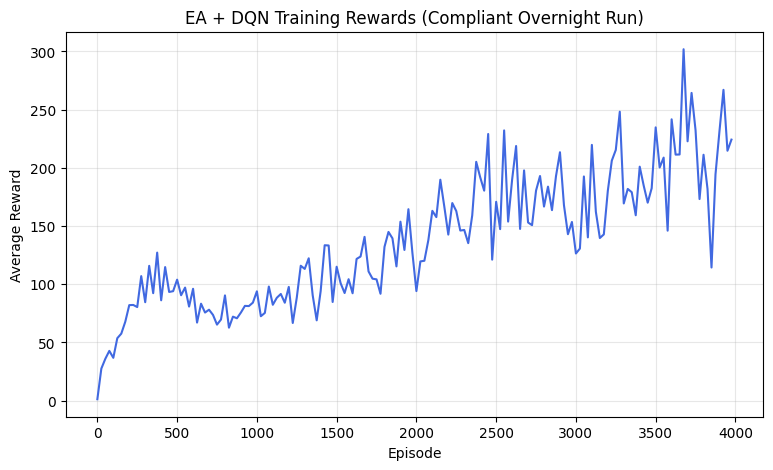

✅ Training complete — weights, rewards, and graph saved.


In [ ]:
#imports relevant libraries 
import torch, torch.nn as nn, torch.optim as optim
import numpy as np, random, gym, os, time, datetime, pandas as pd, matplotlib.pyplot as plt
from collections import deque, namedtuple
from copy import deepcopy

#checks for what the device is running on (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#defines neural network architecture for Q-values
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128) #input layer
        self.fc2 = nn.Linear(128, 128) #hidden layer
        self.fc3 = nn.Linear(128, action_dim) #hidden layer to output layer
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#stores agent experiences
Transition = namedtuple("Transition", ("observation", "action", "next_observation", "reward", "done"))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) #stores experience tuples
    def push(self, *args):
        self.memory.append(Transition(*args)) #adds transition to memory
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) #randomly samples batch for training
    def __len__(self):
        return len(self.memory) #returns current number of stored transitions

# functions for utility 
def pick_action(epsilon, policy_net, env, obs): #epsilon greedy policy for balancing between exploration and exploitation
    if random.random() < epsilon:
        return env.action_space.sample()
    if isinstance(obs, np.ndarray):
        obs = torch.tensor(obs, dtype=torch.float32).to(device)
    if obs.ndim == 1:
        obs = obs.unsqueeze(0)
    with torch.no_grad(): # picks the greedy action
        return torch.argmax(policy_net(obs)).item()

def sample_batch(replay_buffer, batch_size): #function that gets and converts batch of transitions from memory into tensors
    transitions = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))
    obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.observation])
    next_obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.next_observation])
    a = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
    r = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
    done = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
    return obs.to(device), a.to(device), r.to(device), next_obs.to(device), done.to(device)

# Main DQN Training Function
# DQN training loop for the CartPole-v1 environment.
def baseline_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size):
    env = gym.make("CartPole-v1")
    observation, _ = env.reset()
    policy_net = QNetwork(4, 2).to(device) # Initialize networks (policy and target)
    target_net = QNetwork(4, 2).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayMemory(capacity)
    step_count, total_reward = 0, 0 # set tracking variables
    plot_avg_rewards, start_time = [], time.time()

    os.makedirs("weights", exist_ok=True) # makes main directory for the saved models

    #this is the training loop
    for episode in range(episodes):
        observation, _ = env.reset()
        observation = torch.tensor(observation, dtype=torch.float32).to(device)
        terminated = truncated = False

        env.unwrapped.length = float(np.random.uniform(0.4, 1.8)) #randomizes the pole length

        #main episode loop
        while not terminated and not truncated:
            action = pick_action(epsilon, policy_net, env, observation) #picks action depending on epsilon policy
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_obs = torch.tensor(next_obs, dtype=torch.float32).to(device)
            replay_buffer.push(observation, action, next_obs, reward, terminated) #stores in replay buffer
            observation = next_obs
            total_reward += reward


            if len(replay_buffer) >= batch_size:
                obs, a, r, next_obs, done = sample_batch(replay_buffer, batch_size)
                next_q = target_net(next_obs).max(1, keepdim=True)[0].detach()   # Target Q-value
                td_target = r + gamma * (1 - done) * next_q                     # Bellman equation target
                current_q = policy_net(obs).gather(1, a)                        # Predicted Q-value
                loss = error(current_q, td_target)                       # Temporal difference error
                optimizer.zero_grad(); loss.backward(); optimizer.step()

            step_count += 1

            if step_count % target_update == 0: # Update target network every few steps
                target_net.load_state_dict(policy_net.state_dict())

        
        epsilon = max(0.01, epsilon * 0.9995) # Epsilon decay that reduces exploration gradually

        if episode % 25 == 0: # Log results every 25 episodes
            avg = total_reward / 25
            plot_avg_rewards.append(avg)
            log(f"Episode {episode}/{episodes} | Avg reward: {avg:.2f}")
            total_reward = 0

        if episode % 500 == 0 and episode > 0: # Save model checkpoints every 500 episodes
            torch.save(policy_net.state_dict(), f"weights/backup_model_{episode}.pth")
            log(f"💾 Backup saved at episode {episode}")

    torch.save(policy_net.state_dict(), "weights/baseline_model2.pth")
    env.close()
    return plot_avg_rewards, policy_net

# Defines the possible ranges of hyperparameters that the evolutionary algorithm will explore.:
SPACE = { 
    "learning_rate": ("loguniform", 5e-5, 1e-3),
    "gamma": ("uniform", 0.90, 0.99),
    "epsilon_decay": ("uniform", 0.995, 0.9999),
    "batch_size": ("choice", [32, 64, 128]),
    "capacity": ("choice", [10000, 50000, 100000]),
    "target_update": ("choice", [250, 500, 1000]),
    "epsilon_start": ("choice", [0.8, 1.0]),
    "episodes": ("choice", [400, 800])
}

def sample_value(spec): #Randomly sample a value from a given hyperparameter distribution
    t = spec[0]
    if t == "uniform": return np.random.uniform(spec[1], spec[2])
    if t == "loguniform": return 10 ** np.random.uniform(np.log10(spec[1]), np.log10(spec[2]))
    if t == "choice": return random.choice(spec[1])

def sample_hyperparameters(): #Generate a random individual 
    return {k: sample_value(v) for k, v in SPACE.items()}

def tournament_selection(pop, fitness, k=3): #Selects parents using tournament selection
    selected = []
    for _ in range(len(pop)): # Randomly chooses k individuals and selects the one with the highest fitness as a parent
        contenders = random.sample(list(zip(pop, fitness)), k)
        winner = max(contenders, key=lambda x: x[1])[0]
        selected.append(deepcopy(winner))
    return selected

def crossover(p1, p2, p_crossover=0.8):  #Combines two parents’ hyperparameters to create a child through mixing or copying parent values
    if random.random() > p_crossover:
        return deepcopy(p1)
    child = {}
    for k, spec in SPACE.items():
        if spec[0] in ("uniform", "loguniform"):
            alpha = random.random()
            child[k] = alpha * p1[k] + (1 - alpha) * p2[k]  #Blend numerical hyperparameters between two parents
        else:
            child[k] = random.choice([p1[k], p2[k]]) # Randomly inherit some hyperparameters
    return child

def mutation(ind, rate=0.2): #Introduces random perturbations to the offspring’s hyperparameters
    for k, spec in SPACE.items():
        if random.random() < rate: ind[k] = sample_value(spec)
    return ind

def evaluate_individual(ind): # Trains a DQN agent using the individual’s hyperparameters.
    rewards, _ = baseline_DQN(
        learning_rate=ind["learning_rate"],
        gamma=ind["gamma"],
        episodes=int(ind["episodes"]),
        target_update=int(ind["target_update"]),
        epsilon=ind["epsilon_start"],
        capacity=int(ind["capacity"]),
        batch_size=int(ind["batch_size"]),
    )
    return np.mean(rewards[-5:])  #Returns the mean of the last 5 logged rewards (≈ last 125 episodes) as fitness


def evolve(pop_size=6, generations=3, elite_k=2):
    population = [sample_hyperparameters() for _ in range(pop_size)] #Initialize population.
    best, best_fit = None, -np.inf
    for g in range(1, generations + 1):
        print(f"\n=== Generation {g}/{generations} ===")
        fitness = [evaluate_individual(ind) for ind in population]
        gen_best_idx = int(np.argmax(fitness))
        gen_best_fit = fitness[gen_best_idx] # Evaluate fitness.
        print(f"Gen {g} best fitness = {gen_best_fit:.2f}")
        if gen_best_fit > best_fit: # Update best-so-far record
            best_fit, best = gen_best_fit, deepcopy(population[gen_best_idx])
        parents = tournament_selection(population, fitness) # Selection and reproduction
        next_gen = [mutation(crossover(*random.sample(parents, 2))) for _ in range(pop_size - elite_k)]
        elites = [population[i] for i in np.argsort(fitness)[-elite_k:]]  # Elitism: keep top k individuals directly
        population = elites + next_gen
    print("\n=== Evolution Finished ===")
    print("Best fitness:", round(best_fit, 2))
    print("Best hyperparameters:", best)
    return best

#central/final execultion
if __name__ == "__main__":
    os.makedirs("weights", exist_ok=True)
    best = evolve(pop_size=6, generations=3, elite_k=2) # Run the evolutionary process
    rewards, model = baseline_DQN(  # Train final model with best-evolved hyperparameters
        learning_rate=best["learning_rate"],
        gamma=best["gamma"],
        episodes=4000,  
        target_update=int(best["target_update"]),
        epsilon=best["epsilon_start"],
        capacity=int(best["capacity"]),
        batch_size=int(best["batch_size"]),
    )
    # Save and visualize training results
    pd.DataFrame({"avg_rewards": rewards}).to_csv("EA_DQN_rewards.csv", index=False)
    plt.figure(figsize=(9,5))
    plt.plot(np.arange(len(rewards)) * 25, rewards, color="royalblue")
    plt.title("EA + DQN Training Rewards (Compliant Overnight Run)")
    plt.xlabel("Episode"); plt.ylabel("Average Reward")
    plt.grid(alpha=0.3)
    plt.savefig("EA_DQN_training_curve.png")
    plt.show()
    print("✅ Training complete — weights, rewards, and graph saved.")


In [ ]:

def evaluate_trained_agent(model_path="weights/baseline_model2.pth"):
    env = gym.make("CartPole-v1")
    policy_net = QNetwork(4, 2).to(device)
    policy_net.load_state_dict(torch.load(model_path, map_location=device))
    policy_net.eval()

    pole_lengths = np.linspace(0.4, 1.8, 30)
    avg_rewards = []
    std_rewards = []

    print("Evaluating trained agent across pole lengths...\n")

    for L in pole_lengths:
        env.unwrapped.length = L
        scores = []

        for _ in range(10):  
            obs, _ = env.reset()
            obs = torch.tensor(obs, dtype=torch.float32).to(device)
            total_reward = 0
            done = False
            t = 0

            while not done and t < 5000:
                with torch.no_grad():
                    action = policy_net(obs.unsqueeze(0)).argmax().item()
                next_obs, reward, done, truncated, _ = env.step(action)
                obs = torch.tensor(next_obs, dtype=torch.float32).to(device)
                total_reward += reward
                t += 1

            scores.append(total_reward)

        avg_rewards.append(np.mean(scores))
        std_rewards.append(np.std(scores))
        print(f"Pole length {L:.2f} | Avg: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

    total_reward_sum = np.sum(avg_rewards)
    print(f"Total cumulative reward across all pole lengths = {total_reward_sum:.2f}")

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(pole_lengths)), avg_rewards, yerr=std_rewards, color="royalblue", alpha=0.7)
    plt.xticks(range(len(pole_lengths)), [f"{x:.2f}" for x in pole_lengths], rotation=90)
    plt.title(f"Average Reward over Pole Lengths | Total = {total_reward_sum:.1f}")
    plt.xlabel("Pole Length")
    plt.ylabel("Average Reward")
    plt.tight_layout()
    plt.savefig("EA_DQN_test_results_bar.png")
    plt.show()

    env.close()
    return total_reward_sum
